# Association Rule Mining Lab

**Name:** Your Name  
**Course:** MSCS 634  
**Lab:** Lab 6 Association Rules with Apriori and FP Growth  
**Date:** July 26th 2025

In [1]:
# Imports
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from IPython.display import Markdown, display

pd.set_option('display.max_colwidth', 180)
plt.rcParams['figure.figsize'] = (10, 6)




## Step 1. Data preparation

Choose a transactional dataset. The example below loads the UCI Online Retail dataset. If the online link is blocked, set LOCAL_FILE to a downloaded Excel file.  
Expected columns for the UCI dataset: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country.


In [2]:
# Configure data source
USE_UCI_ONLINE_RETAIL = True
LOCAL_FILE = "OnlineRetail.xlsx"
SUBSET_COUNTRY = None

if USE_UCI_ONLINE_RETAIL:
    uci_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
    try:
        df_raw = pd.read_excel(uci_url)
        source_used = "UCI URL"
    except Exception as e:
        print("Could not download from UCI. Falling back to LOCAL_FILE.")
        print(str(e))
        df_raw = pd.read_excel(LOCAL_FILE)
        source_used = "LOCAL_FILE"
else:
    df_raw = pd.read_excel(LOCAL_FILE)
    source_used = "LOCAL_FILE"

print("Data source:", source_used)
df_raw.head()


Data source: UCI URL


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Clean the dataset

We remove credit invoices, rows with missing item names, and rows with non positive quantity or unit price.  
You may optionally filter to a single country to reduce sparsity.


In [3]:
# Basic cleaning
df = df_raw.copy()

# Keep rows with a valid invoice and item text
df = df.dropna(subset=["InvoiceNo", "Description"])

# Remove credit notes
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

# Keep only positive quantity and price
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Normalize item text
df["Description"] = df["Description"].astype(str).str.strip()

# Optional country subset
if SUBSET_COUNTRY is not None:
    df = df[df["Country"] == SUBSET_COUNTRY]

print("Invoices:", df["InvoiceNo"].nunique())
print("Distinct items:", df["Description"].nunique())
print("Rows after cleaning:", len(df))
df.head()


Invoices: 19960
Distinct items: 4015
Rows after cleaning: 530104


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Exploratory analysis with Seaborn

We will inspect the most frequent items and show a co occurrence heatmap for a subset of frequent items.


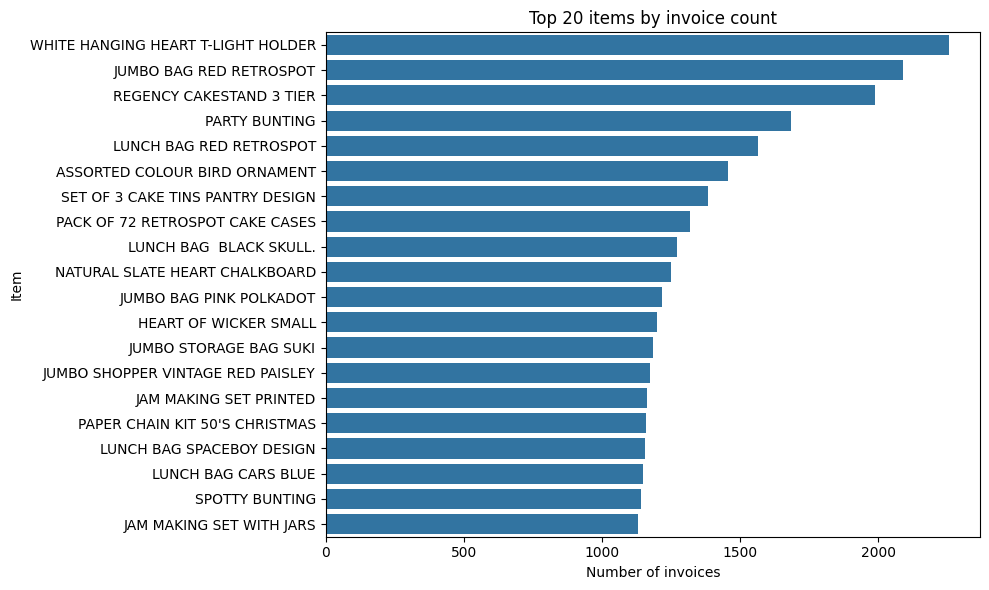

,Description,invoice_count
0,WHITE HANGING HEART T-LIGHT HOLDER,2256
1,JUMBO BAG RED RETROSPOT,2089
2,REGENCY CAKESTAND 3 TIER,1988
3,PARTY BUNTING,1685
4,LUNCH BAG RED RETROSPOT,1564


In [4]:
# Top items by number of invoices they appear in
top_n = min(20, df["Description"].nunique())
item_invoice_counts = (
    df.groupby("Description")["InvoiceNo"].nunique()
      .sort_values(ascending=False)
      .head(top_n)
      .reset_index(name="invoice_count")
)

plt.figure()
sns.barplot(data=item_invoice_counts, x="invoice_count", y="Description")
plt.title(f"Top {top_n} items by invoice count")
plt.xlabel("Number of invoices")
plt.ylabel("Item")
plt.tight_layout()
plt.show()

item_invoice_counts.head()


/tmp/ipython-input-30-3671792334.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_binary = basket_sample.applymap(lambda x: 1 if x > 0 else 0)


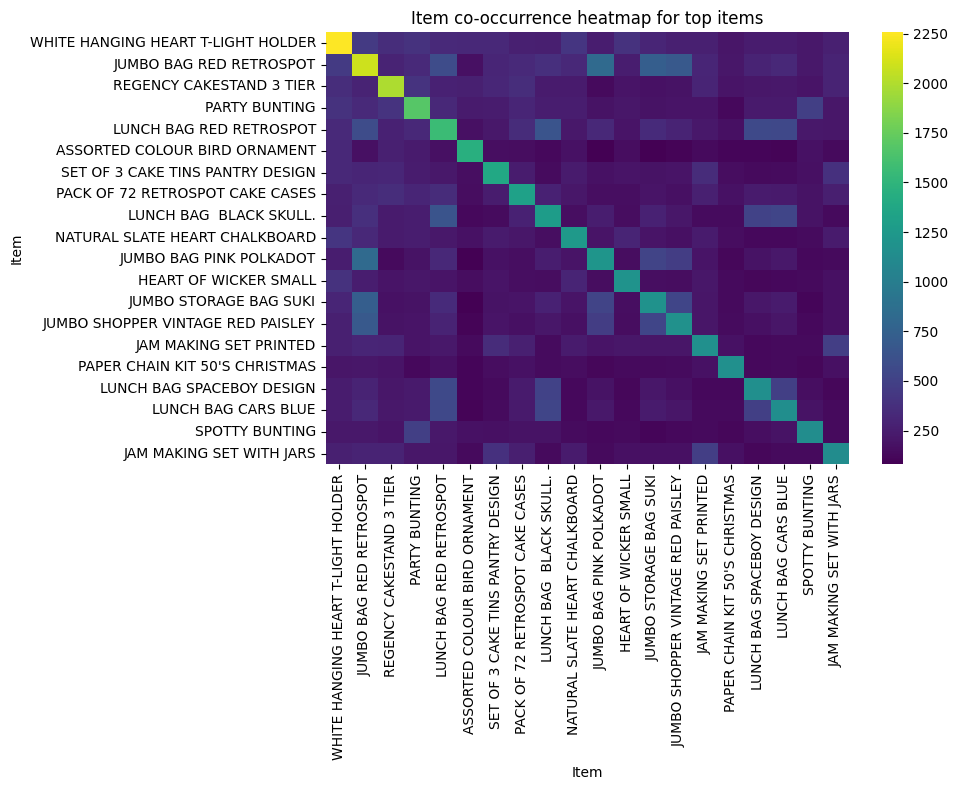

In [30]:
# Co-occurrence heatmap for the top frequent items
top_items = item_invoice_counts["Description"].tolist()

basket_sample = (
    df.groupby(["InvoiceNo", "Description"])["Quantity"]
      .sum()
      .unstack(fill_value=0)
)

# Keep only available top items to avoid KeyError
available_items = [c for c in top_items if c in basket_sample.columns]
basket_sample = basket_sample[available_items]

# Binary presence
basket_binary = basket_sample.applymap(lambda x: 1 if x > 0 else 0)

# Co-occurrence counts
co_matrix = pd.DataFrame(
    basket_binary.T.dot(basket_binary),
    index=available_items,
    columns=available_items
)

plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, cmap="viridis")
plt.title("Item co-occurrence heatmap for top items")
plt.xlabel("Item")
plt.ylabel("Item")
plt.tight_layout()
plt.show()


## Step 2. Frequent itemset mining with Apriori

We build a full one hot basket and run Apriori with a chosen minimum support. Adjust min_support and max_len based on dataset size.


In [20]:
# Drop ultra rare items to reduce width
min_item_invoices = 20  # keep items that appear in at least 20 invoices
item_counts = df.groupby("Description")["InvoiceNo"].nunique()
popular_items = item_counts[item_counts >= min_item_invoices].index
df = df[df["Description"].isin(popular_items)]

print("After rare item filter")
print("Invoices:", df["InvoiceNo"].nunique())
print("Distinct items:", df["Description"].nunique())
print("Rows:", len(df))


After rare item filter
Invoices: 19872
Distinct items: 2858
Rows: 521814


In [21]:
# Apriori with compact basket and stronger support
basket_all = (
    df.groupby(["InvoiceNo", "Description"])["Quantity"]
      .sum()
      .unstack(fill_value=0)
      .astype("uint8")
).clip(upper=1)

n_tx, n_items = basket_all.shape
approx_mem_mb = basket_all.memory_usage(deep=True).sum() / (1024 * 1024)
print("Basket shape:", basket_all.shape, f"~{approx_mem_mb:.1f} MB")

# Stronger minimum support suited to Online Retail scale
# 2 percent of invoices is a good starting point for speed and quality
min_support = 0.02
max_len = 2

print(f"Using min_support = {min_support:.4f}, max_len = {max_len}")

start = time.time()
freq_apriori = apriori(
    basket_all,
    min_support=min_support,
    use_colnames=True,
    max_len=max_len,
    low_memory=True
)
elapsed_apriori = time.time() - start

freq_apriori = freq_apriori.sort_values("support", ascending=False).reset_index(drop=True)
print(f"Apriori found {len(freq_apriori)} itemsets in {elapsed_apriori:.2f} seconds")
freq_apriori.head()


Basket shape: (19872, 2858) ~54.3 MB
Using min_support = 0.0200, max_len = 2


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Apriori found 378 itemsets in 0.67 seconds


,support,itemsets
0,0.113426,(WHITE HANGING HEART T-LIGHT HOLDER)
1,0.105123,(JUMBO BAG RED RETROSPOT)
2,0.100040,(REGENCY CAKESTAND 3 TIER)
3,0.084793,(PARTY BUNTING)
4,0.078704,(LUNCH BAG RED RETROSPOT)


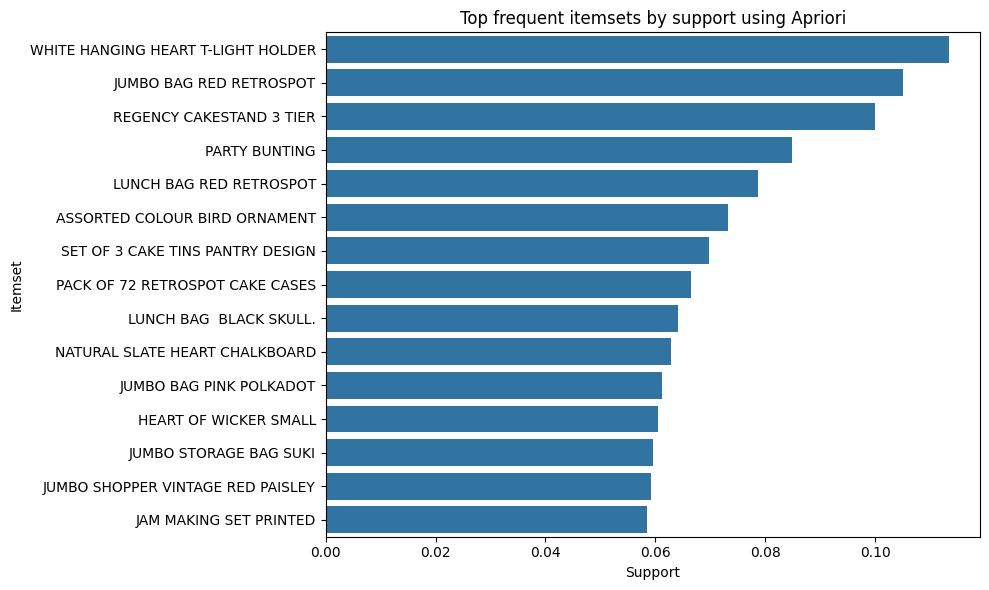

,itemset_str,support
0,WHITE HANGING HEART T-LIGHT HOLDER,0.113426
1,JUMBO BAG RED RETROSPOT,0.105123
2,REGENCY CAKESTAND 3 TIER,0.100040
3,PARTY BUNTING,0.084793
4,LUNCH BAG RED RETROSPOT,0.078704
5,ASSORTED COLOUR BIRD ORNAMENT,0.073219
6,SET OF 3 CAKE TINS PANTRY DESIGN,0.069696
7,PACK OF 72 RETROSPOT CAKE CASES,0.066425
8,LUNCH BAG BLACK SKULL.,0.064060
9,NATURAL SLATE HEART CHALKBOARD,0.062852


In [22]:
# Visualize top frequent itemsets from Apriori
N = 15
top_itemsets_ap = freq_apriori.head(N).copy()
top_itemsets_ap["itemset_str"] = top_itemsets_ap["itemsets"].apply(lambda s: ", ".join(sorted(list(s))))

plt.figure()
sns.barplot(data=top_itemsets_ap, x="support", y="itemset_str")
plt.title("Top frequent itemsets by support using Apriori")
plt.xlabel("Support")
plt.ylabel("Itemset")
plt.tight_layout()
plt.show()

top_itemsets_ap[["itemset_str", "support"]]


## Step 3. Frequent itemset mining with FP Growth

Run FP Growth with the same thresholds and compare runtime and number of patterns.


In [23]:
# FP Growth with the same thresholds as Apriori
start = time.time()
freq_fpg = fpgrowth(
    basket_all,
    min_support=min_support,   # same threshold as Apriori
    use_colnames=True,
    max_len=max_len            # same max_len as Apriori
)
elapsed_fpg = time.time() - start

freq_fpg = freq_fpg.sort_values("support", ascending=False).reset_index(drop=True)
print(f"FP Growth found {len(freq_fpg)} itemsets in {elapsed_fpg:.2f} seconds")
freq_fpg.head()


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


FP Growth found 378 itemsets in 11.99 seconds


,support,itemsets
0,0.113426,(WHITE HANGING HEART T-LIGHT HOLDER)
1,0.105123,(JUMBO BAG RED RETROSPOT)
2,0.100040,(REGENCY CAKESTAND 3 TIER)
3,0.084793,(PARTY BUNTING)
4,0.078704,(LUNCH BAG RED RETROSPOT)


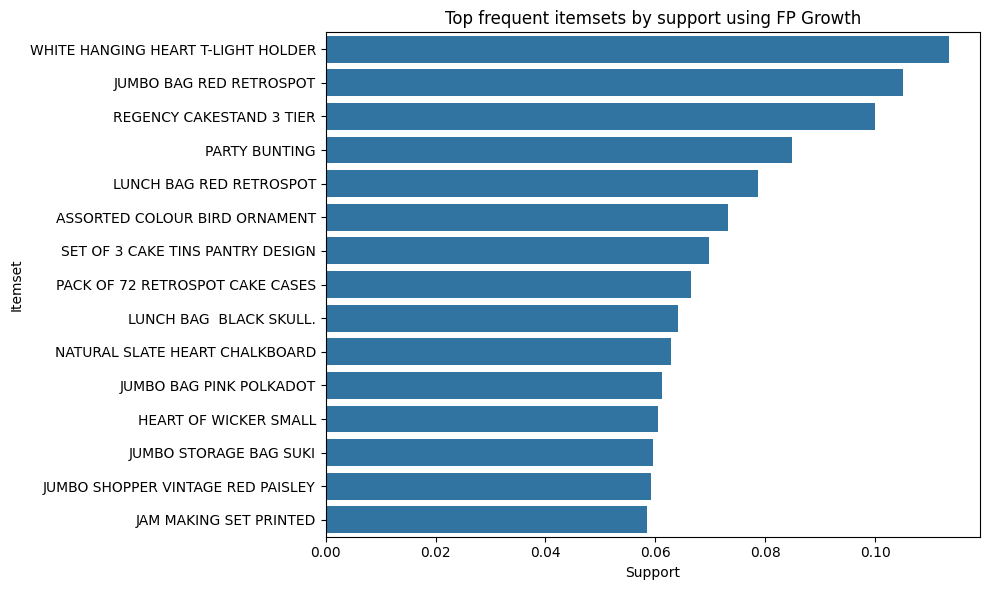

,itemset_str,support
0,WHITE HANGING HEART T-LIGHT HOLDER,0.113426
1,JUMBO BAG RED RETROSPOT,0.105123
2,REGENCY CAKESTAND 3 TIER,0.100040
3,PARTY BUNTING,0.084793
4,LUNCH BAG RED RETROSPOT,0.078704
5,ASSORTED COLOUR BIRD ORNAMENT,0.073219
6,SET OF 3 CAKE TINS PANTRY DESIGN,0.069696
7,PACK OF 72 RETROSPOT CAKE CASES,0.066425
8,LUNCH BAG BLACK SKULL.,0.064060
9,NATURAL SLATE HEART CHALKBOARD,0.062852


In [24]:
# Visualize top frequent itemsets from FP Growth
top_itemsets_fp = freq_fpg.head(N).copy()
top_itemsets_fp["itemset_str"] = top_itemsets_fp["itemsets"].apply(lambda s: ", ".join(sorted(list(s))))

plt.figure()
sns.barplot(data=top_itemsets_fp, x="support", y="itemset_str")
plt.title("Top frequent itemsets by support using FP Growth")
plt.xlabel("Support")
plt.ylabel("Itemset")
plt.tight_layout()
plt.show()

top_itemsets_fp[["itemset_str", "support"]]


## Step 4. Generate and analyze association rules

We compute rules from both itemset collections using a confidence threshold. We include support, confidence, and lift. We also visualize confidence versus lift to identify strong rules.


In [25]:
# Rules from Apriori itemsets
min_conf = 0.6 if n_tx < 1000 else 0.5   # slightly higher confidence on small samples

rules_ap = association_rules(freq_apriori, metric="confidence", min_threshold=min_conf)
rules_ap = rules_ap.sort_values(["confidence", "lift"], ascending=[False, False]).reset_index(drop=True)

print("Apriori rules:", rules_ap.shape)
rules_ap[["antecedents", "consequents", "support", "confidence", "lift"]].head(10)


Apriori rules: (49, 14)


,antecedents,consequents,support,confidence,lift
0,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.031804,0.826144,16.206446
1,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.030042,0.780392,14.575144
2,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.038547,0.756170,14.122750
3,(GARDENERS KNEELING PAD CUP OF TEA),(GARDENERS KNEELING PAD KEEP CALM),0.027476,0.720317,15.678129
4,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038547,0.719925,14.122750
5,(CHARLOTTE BAG PINK POLKADOT),(RED RETROSPOT CHARLOTTE BAG),0.026268,0.703504,13.546543
6,(DOTCOM POSTAGE),(JUMBO BAG RED RETROSPOT),0.024406,0.686969,6.534919
7,(JUMBO BAG PEARS),(JUMBO BAG APPLES),0.020431,0.682353,13.864742
8,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.041516,0.677340,6.443321
9,(JUMBO BAG SCANDINAVIAN BLUE PAISLEY),(JUMBO BAG RED RETROSPOT),0.022544,0.676737,6.437588


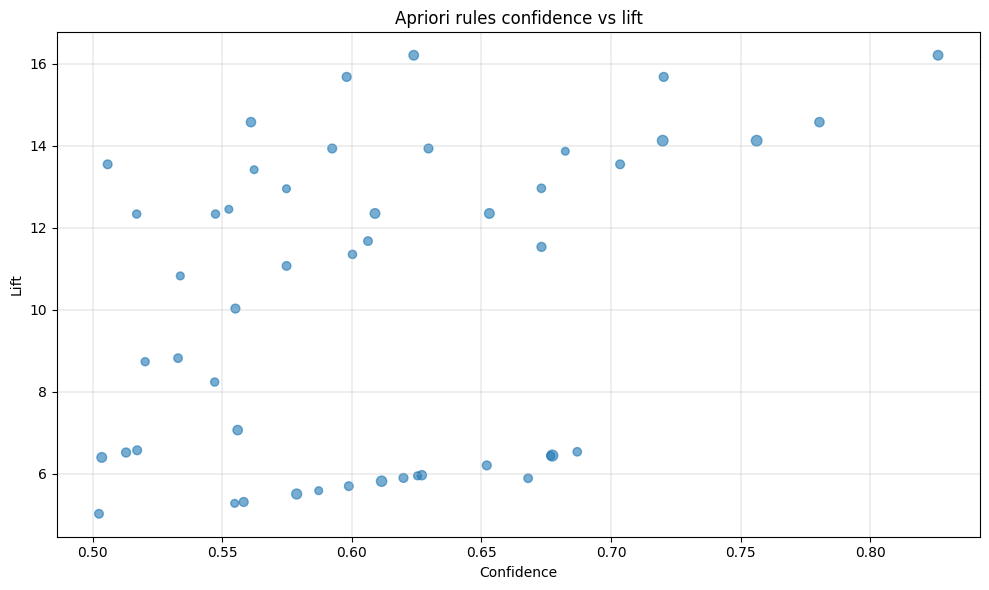

In [26]:
# Scatter for Apriori rules: confidence vs lift, bubble size by support
plt.figure()
plt.scatter(rules_ap["confidence"], rules_ap["lift"], s=rules_ap["support"] * 1500, alpha=0.6)
plt.title("Apriori rules confidence vs lift")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()


In [17]:
# Rules from FP Growth itemsets
rules_fp = association_rules(freq_fpg, metric="confidence", min_threshold=min_conf)
rules_fp = rules_fp.sort_values(["confidence", "lift"], ascending=[False, False]).reset_index(drop=True)

print("FP Growth rules:", rules_fp.shape)
rules_fp[["antecedents", "consequents", "support", "confidence", "lift"]].head(10)


FP Growth rules: (49, 14)


,antecedents,consequents,support,confidence,lift
0,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.031804,0.826144,16.206446
1,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.030042,0.780392,14.575144
2,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.038547,0.756170,14.122750
3,(GARDENERS KNEELING PAD CUP OF TEA),(GARDENERS KNEELING PAD KEEP CALM),0.027476,0.720317,15.678129
4,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038547,0.719925,14.122750
5,(CHARLOTTE BAG PINK POLKADOT),(RED RETROSPOT CHARLOTTE BAG),0.026268,0.703504,13.546543
6,(DOTCOM POSTAGE),(JUMBO BAG RED RETROSPOT),0.024406,0.686969,6.534919
7,(JUMBO BAG PEARS),(JUMBO BAG APPLES),0.020431,0.682353,13.864742
8,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.041516,0.677340,6.443321
9,(JUMBO BAG SCANDINAVIAN BLUE PAISLEY),(JUMBO BAG RED RETROSPOT),0.022544,0.676737,6.437588


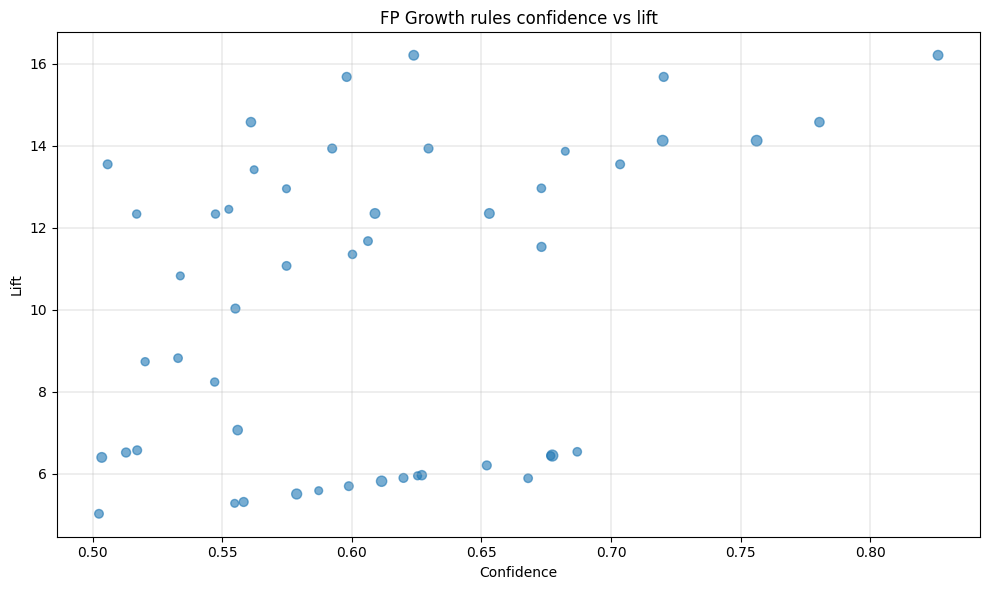

In [27]:
# Scatter for FP Growth rules: confidence vs lift, bubble size by support
plt.figure()
plt.scatter(rules_fp["confidence"], rules_fp["lift"], s=rules_fp["support"] * 1500, alpha=0.6)
plt.title("FP Growth rules confidence vs lift")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.grid(True, linewidth=0.3)
plt.tight_layout()
plt.show()


## Step 5. Comparative analysis

Use the summary below to guide your written analysis. Discuss speed, number of patterns, and differences in top itemsets and rules. Explain why one algorithm was faster. FP Growth avoids candidate generation, which often helps on larger or denser datasets.


In [29]:
# Auto summary
summary_text = (
    f"Dataset rows after cleaning: {len(df)}\n"
    f"Invoices: {df['InvoiceNo'].nunique()}  Items: {df['Description'].nunique()}\n"
    f"Basket shape: {basket_all.shape[0]} invoices by {basket_all.shape[1]} items  "
    f"approx memory {basket_all.memory_usage(deep=True).sum() / (1024*1024):.1f} MB\n"
    f"min_support used: {min_support:.4f}  max_len: {max_len}\n"
    f"Apriori itemsets: {len(freq_apriori)} in {elapsed_apriori:.2f} seconds\n"
    f"FP Growth itemsets: {len(freq_fpg)} in {elapsed_fpg:.2f} seconds\n"
    f"Apriori rules: {len(rules_ap)} with min_conf {min_conf}\n"
    f"FP Growth rules: {len(rules_fp)} with min_conf {min_conf}\n\n"
)

display(Markdown("### Run summary"))
print(summary_text)


### Run summary

Dataset rows after cleaning: 521814
Invoices: 19872  Items: 2858
Basket shape: 19872 invoices by 2858 items  approx memory 54.3 MB
min_support used: 0.0200  max_len: 2
Apriori itemsets: 378 in 0.67 seconds
FP Growth itemsets: 378 in 11.99 seconds
Apriori rules: 49 with min_conf 0.5
FP Growth rules: 49 with min_conf 0.5


